In [1]:
from __future__ import division
from covertrace.data_array import Sites
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import abspath, dirname, join
from scipy.integrate import odeint
from scipy.optimize import minimize
%matplotlib inline

In [2]:
from covertrace.utils.kinase_estimation_inh import fit_params_inhibitor
from covertrace.utils.kinase_estimation_dynamics import fit_trapezoid

In [3]:
from covertrace import ops_filter
from covertrace import ops_plotter
from covertrace import ops_bool

In [4]:
data_folder = join(dirname(abspath(os.curdir)), 'covertrackdev', 'output')

## Parameters from literature

r<sub>total</sub>, k<sub>cat</sub> and K<sub>m</sub> is taken from previous works. 

In [5]:
r_total = 0.4  # uM
k_cat = 20  # 1/min
Km = 3  # uM

## Estimation of cytosolic to nuclear volume ratio: k<sub>v</sub>

First obtain the parameter k<sub>v</sub>, ratio of cytosolic volume to nuclear volume. 

Since total reporter concentration is constant at a time scale of our experiments,  
$r_{c,1} + \dfrac{r_{n,1}}{k_v} = r_{c,2} + \dfrac{r_{n,2}}{k_v}$ where $r_{c,i}$ and $r_{n,i}$ are the cytosolic and nuclear concentrations of the reporter in condition *i*.  
Solving for $k_v$, we get  
$k_v = \dfrac{r_{n,2} - r_{n,1}}{r_{c,1} - r_{c,2}}$.  
Larger dynamic range will give you a better estimation of $k_v$ due to the measurement noise.  Thus, we use the condition where JNK reporter is activated by anisomycin and then inhibited by JNK inhibitor. 

In [6]:
parent_folder = join(data_folder, 'AnisoInh')
sub_folders = ['Pos001', 'Pos002']
conditions = ['AnisoInh', 'AnisoInh']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')
# Merge cells from two sites.
sites.merge_conditions()

Pos001: file_name is updated to arr_modified.npz


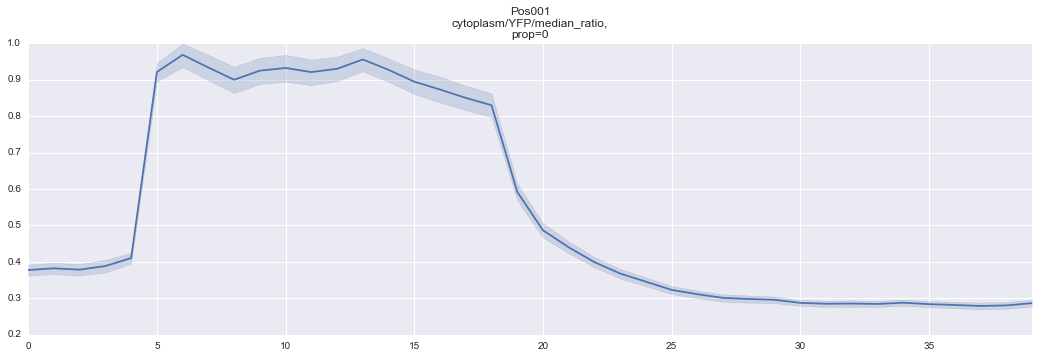

In [7]:
# Take a look at average traces for the cytoplasmic/nuclear ratio of median intensity. This is based on cleaned dataset.
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)

You see the cytoplasmic translocation of JNK KTR at frame 5 when cells are stimulated at anisomycin and 
then nuclear translocation at frame 18 when they are inhibited with JNK IVV inhibitor.  
This combination of activation and inactivation will provide a large dynamic range, helping robust parameter estimation. 

Again, we use $k_v = \dfrac{r_{n,2} - r_{n,1}}{r_{c,1} - r_{c,2}}$ for getting $k_v$.  
Let's take frame 7 and frame 35 for two conditions. 


In [8]:
site = sites.Pos001
idx_condition_1 = 7
idx_condition_2 = 35
r_n_1 = np.nanmedian(site.data['nuclei', 'YFP', 'median_intensity'][:, idx_condition_1])
r_n_2 = np.nanmedian(site.data['nuclei', 'YFP', 'median_intensity'][:, idx_condition_2])
r_c_1 = np.nanmedian(site.data['cytoplasm', 'YFP', 'median_intensity'][:, idx_condition_1])
r_c_2 = np.nanmedian(site.data['cytoplasm', 'YFP', 'median_intensity'][:, idx_condition_2])
estimated_k_v = (r_n_2 - r_n_1)/(r_c_1 - r_c_2)
print estimated_k_v

3.79176201373


## Estimation of import and export rate constants: k<sub>iu</sub>, k<sub>eu</sub>, k<sub>ip</sub>, k<sub>ep</sub>

The cytoplasmic translocation of KTR happens because phosphorylation decreases the export rate and increases
the import rate. Thus we would like to know the import and export rate contants for both phosphorylated reporters and 
non-phosphorylated reporters. 
To estimate these constants, we utilize the fact that JNK KTR AA and JNK KTR EE mutants approximate the unphosphorylated 
and phosphorylated state of the wild-type JNK KTR, respectively. 

In [217]:
parent_folder_mut = join(data_folder, 'LMB')
sub_folders_mut = ['Pos003', 'Pos004', 'Pos005', 'Pos006']
conditions_mut = ['JNK_AA', 'JNK_AA', 'JNK_EE', 'JNK_EE']
sites_mut = Sites(parent_folder_mut, sub_folders_mut, conditions_mut, file_name='df_cleaned.npz')
sites_mut.merge_conditions()


Pos003: file_name is updated to arr_modified.npz


Leptomycin B was added at frame 3 and you see a decrease of export led to the nuclear translocation.

[<matplotlib.text.Text at 0x120a12ad0>, <matplotlib.text.Text at 0x120db0050>]

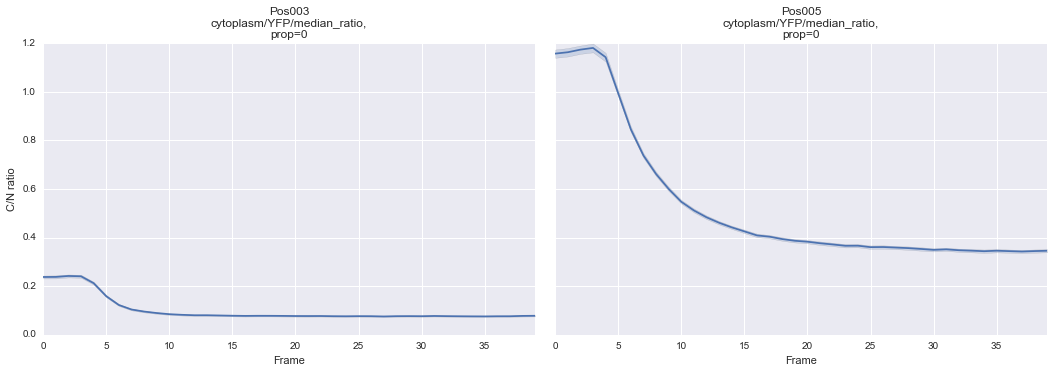

In [582]:
sites_mut.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
fig, axes = sites_mut.iterate(plot_tsplot)
axes[0].set_ylabel('C/N ratio')
[ax.set_xlabel('Frame') for ax in axes]

In [583]:
aa_ratio = sites_mut.Pos003.data['cytoplasm', 'YFP', 'median_ratio']
ee_ratio = sites_mut.Pos005.data['cytoplasm', 'YFP', 'median_ratio']

Efficiency of inhibition varies from cell-to-cell. This is expressed by parameter $h$; upon inhibition at time *t_inh*, export rate will change from $k_e$ to $hk_e$.  
Since phosphorylation does not happen to these mutants, we assume k<sub>e/i</sub> for AA mutants as k<sub>eu/iu</sub> and k<sub>e/i</sub> for EE mutants as k<sub>ep/ip</sub>.
This will give you a following system to decribe a reporter concentration in nucleus (r<sub>n</sub>) and cytoplasm (r<sub>c</sub>).

$\dfrac{dr_c}{dt} = -k_i  r_c + k_e  r_n$  
$\dfrac{dr_n}{dt} = k_v  k_i  r_c - k_v  k_e  r_n$

In [910]:
# Describe this system as ODE
def ode_mutant_model(y, t, *args):
    k_v, k_i, p_k_e, h, inh_t = args[0], args[1], args[2], args[3], args[4]
    if t > inh_t:
        k_e = p_k_e * h
    else:
        k_e = p_k_e
    r_c, r_n = y[0], y[1]
    d_r_c = -k_i * r_c + k_e * r_n
    d_r_n = k_v * k_i * r_c - k_v * k_e * r_n
    return [d_r_c, d_r_n]

In [911]:
# h can be calculated based on steady states at the beginning and at the end. 
h_aa, h_ee = [], []
for cell in aa_ratio:
    h_aa.append(np.mean(cell[30:])/np.mean(cell[:3]))
for cell in ee_ratio:
    h_ee.append(np.mean(cell[30:])/np.mean(cell[:3]))

We would like to find the parameters h, k_e and k_i such that the model reproduces the time sereis of LMB treatment experiment. Write a function that receives h, k_e and k_i and returns the predicted time course of C/N ratio.

In [1182]:
# define a wrapper function that receives k_e and k_i and run a simulation. 
def calc_ts_sim_ratio(x, time, k_v, inh_t, h):
    ei_ratio = x[0]
    k_i = x[1]
    k_e = ei_ratio * k_i
    
    ini_r_c = 1.0
    ini_r_n = 1/ei_ratio
    params = (k_v, k_i, k_e, h, inh_t)
    ts_inh = odeint(ode_mutant_model, [ini_r_c, ini_r_n], time, params, rtol=1e-4)
    ts_sim_ratio = np.array([i[0]/i[1] for i in ts_inh])  # convert reporter profile to cytoplasmic/nuclear ratio
    return ts_sim_ratio

In [1183]:
time = np.arange(0, 40) * 0.5 # /min, Imaged every 30 sec
inh_t = 2.0   # /min, timing of inihibiton
bnds = ((1e-6, None), (1e-6, None))  # boundary for h, k_i and k_e

To begin with, start estimation for a single cell. 

In [1184]:
# We want to fit against the changes in dynamics since k_e and k_i are relative against steady states. 
# Set time index. 


Run a simulation just for a single cell in EE mutants.  
Since EE mutants reaches to the steady around frame 30, we will simulate the decay from frame 0 to frame 30.  
Before the stimulation, $\dfrac{k_e}{k_i} = \dfrac{r_c}{r_n}$. We will constrain the solution by setting ${k_e} >= 0.8 * \dfrac{r_c}{r_n}k_i$.

In [1185]:
t_start = 0
t_end = None
time_ee = time[t_start:t_end]
cell_id = 5
first_cell = ee_ratio[cell_id, :][t_start:t_end]  # time-series of C/N ratio of a cell.

func = lambda x: ((calc_ts_sim_ratio(x, time_ee, estimated_k_v, t_inh, h_ee[cell_id]) - first_cell)**2).sum()  # objective function
# cons_ee = ({'type': 'ineq', 'fun': lambda x:  x[0] - 0.75 * np.mean(first_cell[:3]) * x[1]})  # export is bigger than 0.5 * import
ret = minimize(func, x0=[np.mean(first_cell[:1]), 0.1], bounds=bnds, method='BFGS')  # run the optimization
est_ei_ratio, est_k_i = ret.x  # parameters
est_k_e = est_ei_ratio * est_k_i
print est_k_e, est_k_i

0.116747660001 0.112989624358


After estimating the parameters, we can compare the predicted time-course and experimental time-course for this cell.

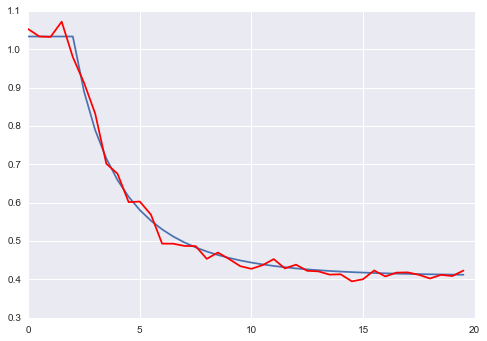

In [1186]:
# using the estimated parameters, run a simulation and compare it to the experimental values.
ts_inh = odeint(ode_mutant_model, [est_k_e, est_k_i], time_ee,  (estimated_k_v, est_k_i, est_k_e, h_ee[cell_id], t_inh), rtol=1e-4)
plt.plot(time_ee, np.array([i[0]/i[1] for i in ts_inh]))
plt.hold(True)
plt.plot(time_ee, first_cell, 'r');

Now we expand this for all the cells from this experiement. 

In [1187]:
# Now run a simulation for all the cells in EE mutants.
param_ee_store = []

t_start = 0
t_end = None
time_ee = time[t_start:t_end]

for cell, sc_h in zip(ee_ratio, h_ee):
#     cons_ee = ({'type': 'ineq', 'fun': lambda x:  x[0] - 1.0})  # export is bigger than 0.5 * import
    func = lambda x: ((calc_ts_sim_ratio(x, time_ee, estimated_k_v, t_inh, sc_h) - cell[t_start:t_end])**2).sum()
#     ret = minimize(func, x0=[np.mean(cell[:1]), 0.1], bounds=bnds, constraints=cons_ee)
    ret = minimize(func, x0=[np.mean(cell[:3]), 0.1], bounds=bnds, method='L-BFGS-B')
    param_ee_store.append(ret.x)
est_k_ip = [i[1] for i in param_ee_store]
est_k_ep = [i[0]*i[1] for i in param_ee_store]

print np.median(est_k_ep)

0.13853224358


Now run a simulation for all the cells in AA mutants.  
Parameter estimation for A mutants is more sensitive than EE mutants due to its small dynamic range.  
First, since it reaches to the steady state faster than EE mutant does, set t_end to 10.  
In addition, for every cells, we assume that k_i is larger than the half of the median k_ep and k_e is smaller than the half of the of EE mutants in every cells.


In [1188]:
param_aa_store = []

t_start = 0
t_end = None
time_aa = time[t_start:t_end]

cons_aa = ({'type': 'ineq', 'fun': lambda x:  x[1] - np.median(est_k_ip)},
           {'type': 'ineq', 'fun': lambda x:  np.median(est_k_ep) - x[0]*x[1]})
for cell, sc_h in zip(aa_ratio, h_aa):
    func = lambda x: ((calc_ts_sim_ratio(x, time_aa, estimated_k_v, t_inh, sc_h) - cell[t_start:t_end])**2).sum()
    ret = minimize(func, x0=[np.mean(cell[:3]), 0.1], bounds=bnds, constraints=cons_aa)
    param_aa_store.append(ret.x)

est_k_eu = [i[0]*i[1] for i in param_aa_store]
est_k_iu = [i[1] for i in param_aa_store]

In [1189]:
median_rate = [np.median(est_k_eu), np.median(est_k_iu), np.median(est_k_ep), np.median(est_k_ip)]
# median_rate = [np.mean(est_k_eu), np.mean(est_k_iu), np.mean(est_k_ep), np.mean(est_k_ip)]
print 'k_eu: {0}\t\tk_iu: {1}\t\tk_ep: {2}\t\tk_ip: {3}'.format(*median_rate)

k_eu: 0.138531200716		k_iu: 0.587147372077		k_ep: 0.13853224358		k_ip: 0.114478879877


## Estimation of dephosphorylation parameters: k<sub>d</sub> and K<sub>md</sub>

k<sub>d</sub> and K<sub>md</sub> are the maximum dephosphorylation rate and Michaelis constant of reporter dephosphorylation, respectively. Here we assume k<sub>d</sub> is equal in both cytosol and nucleus.

Here we are going to use the median of the parameters estimated in the previous sections. Make a dictionary of parameter set.

In [293]:
# Define a parameter set from the previous analysis. 
param_set = dict(k_v=estimated_k_v, 
                 k_iu=np.median(est_k_iu), k_eu=np.median(est_k_eu), 
                 k_ip=np.median(est_k_ip), k_ep=np.median(est_k_ep),
                 k_cat=k_cat, Km=Km, r_total=r_total)

In [295]:
param_set['k_iu'] = 0.44
param_set['k_eu'] = 0.11
param_set['k_ip'] = 0.16
param_set['k_ep'] = 0.2

Now make an model for KTR system describing the phosphorylation, dephosphorylation and nuclear-cytosolic shuttling of the KTR. 

In [276]:
# Let's define the system with all of the parameters
def main_ode(y, t, p):
    c_u, n_u, c_p, n_p = y[0], y[1], y[2], y[3]

    k_v = p['k_v']
    k_iu, k_eu, k_ip, k_ep = p['k_iu'], p['k_eu'], p['k_ip'], p['k_ep']
    k_cat, Km, r_total = p['k_cat'], p['Km'], p['r_total']
    k_dc, k_dn, Kmd = p['k_d'], p['k_d'], p['Kmd']
    kin_c_func, kin_n_func = p['kin_c_func'], p['kin_n_func']

    d_c_u = -kin_c_func(t) * k_cat * c_u/(c_u+Km)\
        + k_dc * c_p/(c_p + Kmd) - k_iu * c_u + k_eu * n_u
    d_n_u = -kin_n_func(t) * k_cat * n_u/(n_u + Km) + k_dn * n_p/(n_p + Kmd)\
        + k_v * k_iu * c_u - k_v * k_eu * n_u
    d_c_p = kin_c_func(t) * k_cat * c_u/(c_u + Km) - k_dc * c_p/(c_p + Kmd)\
        - k_ip * c_p + k_ep * n_p
    d_n_p = r_total - c_u - n_u/k_v - c_p - n_p/k_v
    return [d_c_u, d_n_u, d_c_p, d_n_p]

Now in order to estimate k_d and Km, we fit the paremeters by simulating the model such that they reproduces the decay of C/N ratio after the inhibitor treatment. We assume that JNK inhibitor decreases kinase activation instantly after the treatment and the extent of inhibition varies from cell to cell.  
The system is in steady state before the inhibiton; at given C/N ratio, we calculate the reporter profile (r_cu, r_nu, r_cp, r_np). 

In [277]:
# First make a wrapper function to calculate reporter profile at steady state given active kinase concentration.
def calc_rep_profile_at_steady_state(kin, pset):
    """At given kinase concentration and parameters,
    calculate the reporter profile (c_u, n_u, c_p, c_p)
    such that it minimizes sum of squared dy, meaning at pseudo-steady state.
    
    Output: reporter profile, 
            C/N ratio
    """    
    ub = pset['r_total']
    bnds = ((0, ub), (0, ub), (0, ub), (0, ub))
    kin = float(kin)
    pset['kin_c_func'] = lambda t: np.interp(t, [0, 1], [kin, kin])
    pset['kin_n_func'] = lambda t: np.interp(t, [0, 1], [kin, kin])

    x0 = [ub/4, ub/4, ub/4, ub/4]

    func = lambda y: (np.array(main_ode(y, 0, pset))**2).sum()
    ret = minimize(func, x0=x0, bounds=bnds, method='BFGS', tol=1e-4)
    return ret.x

def calc_rcn_at_steady_state(kin, pset):
    x = calc_rep_profile_at_steady_state(kin, pset)
    return (x[0] + x[2])/(x[1] + x[3])

In [278]:
def inhibitor_ode_old(x, time, rcn_init, pset):
    pset['k_d'] = x[0]
    pset['Kmd'] = x[1]
    rcn_final = x[2]

    # Calculate kinase concentration at steady state such that it matches with rcn
    #stimate kinase at initial steady state
    func = lambda kin: ((calc_rcn_at_steady_state(kin, pset) - rcn_init)**2).sum()
    ret = minimize(func, x0=[0.01], bounds=((0, None), ))
    # At given kinase concentration, calculate reporter profile.
    y0 = calc_rep_profile_at_steady_state(ret.x[0], pset)
    # At given rcn_final, calculate kinase concentration at final steady state.
    func = lambda kin: ((calc_rcn_at_steady_state(kin, pset) - rcn_final)**2).sum()
    ret = minimize(func, x0=[0.01], bounds=((0, None), ))
    kin_after_inh = ret.x[0]
    
    pset['kin_c_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])
    pset['kin_n_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])

    # At time 0, inihibition started. kinase is inactive so it follows kinase (rcn_final)
    # but reporter profile at time 0 follows y0. Calculate cytoplasmic to nuclear times series.
    ts = odeint(main_ode, y0, time, (pset, ), rtol=1e-4)
    return (ts[:, 0] + ts[:, 2])/(ts[:, 1] + ts[:, 3])

def inhibitor_ode(x, time, rcn_init, rcn_final, pset):
    pset['k_d'] = x[0]
    pset['Kmd'] = x[1]
    # Calculate kinase concentration at steady state such that it matches with rcn
    #stimate kinase at initial steady state
    func = lambda kin: ((calc_rcn_at_steady_state(kin, pset) - rcn_init)**2).sum()
    
    ret = minimize(func, x0=[0.01], bounds=((0, None), ), tol=1e-4)
    # At given kinase concentration, calculate reporter profile.
    y0 = calc_rep_profile_at_steady_state(ret.x[0], pset)
    # At given rcn_final, calculate kinase concentration at final steady state.
    func = lambda kin: ((calc_rcn_at_steady_state(kin, pset) - rcn_final)**2).sum()
    
    ret = minimize(func, x0=[0.01], bounds=((0, None), ), tol=1e-4)
    kin_after_inh = ret.x[0]
    
    pset['kin_c_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])
    pset['kin_n_func'] = lambda t: np.interp(t, [time[0], time[-1]], [kin_after_inh, kin_after_inh])

    # At time 0, inihibition started. kinase is inactive so it follows kinase (rcn_final)
    # but reporter profile at time 0 follows y0. Calculate cytoplasmic to nuclear times series.
    ts = odeint(main_ode, y0, time, (pset, ), rtol=1e-4)
    return (ts[:, 0] + ts[:, 2])/(ts[:, 1] + ts[:, 3])

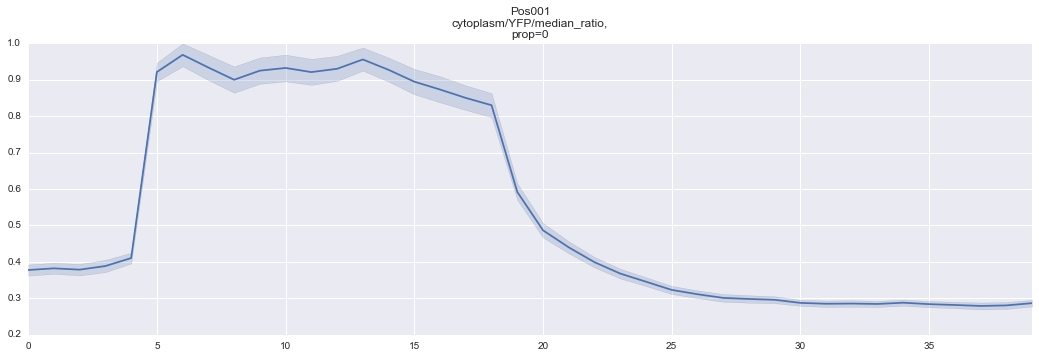

In [285]:
sites.staged.state = ['cytoplasm', 'YFP', 'median_ratio']
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)
site = sites.Pos001

In [286]:
# Let's calcualte this for a single cell first. 
single_rcn = site.data['cytoplasm', 'YFP', 'median_ratio'][5, 18:33]
time = np.arange(len(single_rcn)) * 5  # every 5 min
func = lambda x: ((inhibitor_ode(x, time, single_rcn[0], single_rcn[-1], param_set) - single_rcn)**2).sum()
bnds = ((0, None), (0, None))
ret = minimize(func, x0=[0.05, 0.1], bounds=bnds, method='COBYLA')
# sc_k_d, sc_Kmd, sc_rcn_final = ret.x

In [287]:
sc_k_d, sc_Kmd = ret.x
print ret.x

[ 0.08666401  1.17738284]


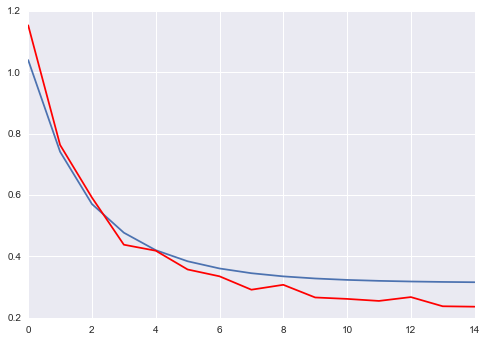

In [271]:
plt.plot(inhibitor_ode([sc_k_d, sc_Kmd], time, single_rcn[0],single_rcn[-1], param_set))
plt.hold(True)
plt.plot(single_rcn, 'r')

In [272]:
# estimate for all the cells. Better with population level? Powell method seems to be slow but consistent. 
# maybe faster to do brute force. 
# k_d_store, Kmd_store = [], []
# for num, rcn in enumerate(site.data['cytoplasm', 'YFP', 'median_ratio'][:, 18:33]):
#     print "calculating for {0}th cell".format(num)
#     func = lambda x: ((inhibitor_ode(x, time, rcn[0], rcn[-1], param_set) - rcn)**2).sum()
#     ret = minimize(func, x0=[0.3, 1], bounds=bnds, method='COBYLA')
#     k_d_store.append(ret.x[0])
#     Kmd_store.append(ret.x[1])

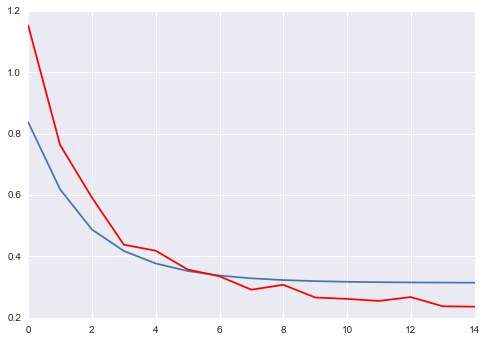

In [273]:
# The estimation of k_d and Kmd for all the single cells takes a time.
# If you want to save a time, estimate them by using median traces of C/N ratio.
# Powell method would take some time..

med_rcn = np.nanmedian(site.data['cytoplasm', 'YFP', 'median_ratio'][:, 18:33], axis=0)
func = lambda x: ((inhibitor_ode(x, time, med_rcn[0], med_rcn[-1], param_set) - med_rcn)**2).sum()
ret = minimize(func, x0=[0.3, 1], bounds=bnds, method='Powell')
est_k_d, est_Kmd = ret.x[0], ret.x[1]

plt.plot(inhibitor_ode([est_k_d, est_Kmd], time, med_rcn[0], med_rcn[-1], param_set))
plt.hold(True)
plt.plot(single_rcn, 'r')

In [274]:
print est_k_d, est_Kmd

0.0886295144696 0.994698861757


## Absolute kinase concentration

In [31]:
parent_folder = join(data_folder, 'IL1B')
sub_folders = ['Pos005', 'Pos006', 'Pos007', 'Pos008']
conditions = ['IL1B', 'IL1B', 'IL1B', 'IL1B']
sites_il1b = Sites(parent_folder, sub_folders, conditions, file_name='df_cleaned.npz')
sites_il1b.merge_conditions()

Pos005: file_name is updated to arr_modified.npz


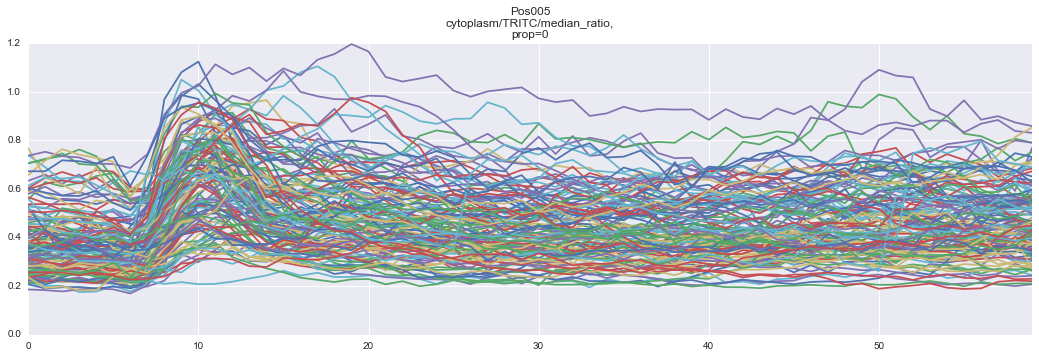

In [32]:
sites_il1b.staged.state = ['cytoplasm', 'TRITC', 'median_ratio']
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites_il1b.iterate(plot_all)

In [33]:
mean_yfp = np.mean(sites_il1b.Pos005.data['cytoplasm', 'YFP', 'median_ratio'], axis=0)
q_store = []
for cell in sites_il1b.Pos005.data['cytoplasm', 'YFP', 'median_ratio']:
    q_store.append(np.mean(cell/mean_yfp))

k_iu_sc, k_ip_sc, k_eu_sc, k_ep_sc = [], [], [], []
for q in q_store:
    k_iu_sc.append(np.median(est_k_iu)/q)
    k_ip_sc.append(np.median(est_k_ip)/q)
    k_eu_sc.append(np.median(est_k_eu) * q)
    k_ep_sc.append(np.median(est_k_ep) * q) 

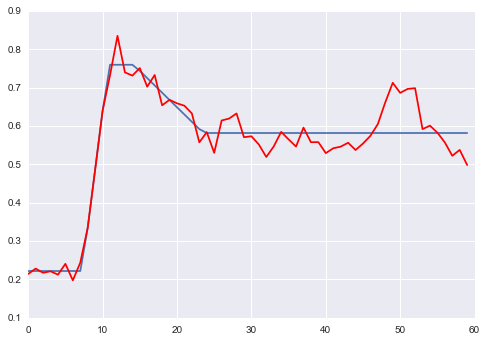

In [97]:
time = np.arange(0, 150, 2.5)  # in minute
single_rcn = sites_il1b.Pos005.data['cytoplasm', 'TRITC', 'median_ratio'][1, :]
param_set['k_iu'] = k_iu_sc[1]
param_set['k_ip'] = k_ip_sc[1]
param_set['k_eu'] = k_eu_sc[1]
param_set['k_ep'] = k_ep_sc[1]

t1, t2, t3, t4, c1, c2, c3 = fit_trapezoid(time, single_rcn)
kin_func = lambda t: np.interp(t, [t1, t2, t3, t4, time[-1]], [c1, c2, c2, c3, c3])
plt.plot(kin_func(time))
plt.hold(True)
plt.plot(single_rcn, 'r')

In [98]:
param_set['kin_c_func'] = kin_func
param_set['kin_n_func'] = kin_func

In [99]:
def kinase_dynamics_ode(kins, time, pset, t1, t2, t3, t4):
    """receives kinase concentration corresponding to C1, C2 and C3 and run a simulation based on those."""
    k1, k2, k3 = kins
    # get model to steady state
    rep0 = calc_rep_profile_at_steady_state(k1, pset)
    pset['kin_c_func'] = lambda t: np.interp(t, [t1, t2, t3, t4, time[-1]], [k1, k2, k2, k3, k3])
    ts = odeint(main_ode, rep0, time, (pset, ), rtol=1e-4)
    return ts

def rcn_dynamics_ode(kins, time, pset, t1, t2, t3, t4):
    rep = kinase_dynamics_ode(kins, time, pset, t1, t2, t3, t4)
    return (rep[:, 0] + rep[:, 2])/(rep[:, 1] + rep[:, 3])

In [ ]:
kin_max=1

In [ ]:
param_set['Kmd'] = 0.1
param_set['k_d'] = 0.03
param_set['k_iu'] = 0.44
param_set['k_eu'] = 0.11
param_set['k_ip'] = 0.16
param_set['k_ep'] = 0.2

In [102]:
func = lambda x: ((rcn_dynamics_ode(x, time, param_set, t1, t2, t3, t4) - kin_func(time))**2).sum()
bnds = ((0, kin_max),) * 3
cons = ({'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x:  x[1] - x[2]})
ret = minimize(func, x0=(kin_max, kin_max, kin_max), constraints=cons, bounds=bnds, method='L-BFGS-B')

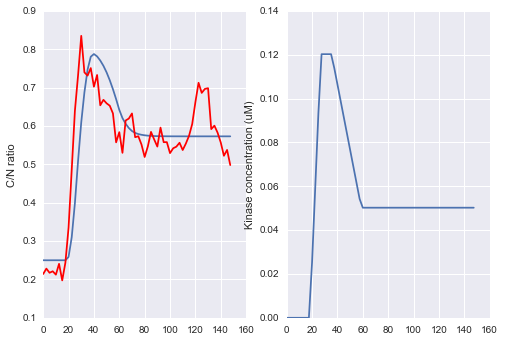

In [103]:
ax1 = plt.subplot(1,2,1)
h1 = plt.plot(time, rcn_dynamics_ode(ret.x, time, param_set, t1, t2, t3, t4))
plt.hold(True)
h2 = plt.plot(time, single_rcn, 'r')
ax1.set_ylabel('C/N ratio')

ax2 = plt.subplot(1,2,2)
kin_ts = np.interp(time, [t1, t2, t3, t4, time[-1]], [ret.x[0], ret.x[1], ret.x[1], ret.x[2], ret.x[2]])
plt.plot(time, kin_ts)
ax2.set_ylabel('Kinase concentration (uM)')